### Parte 1. Lectura de datos crudos.
**Libreria de XM para datos del mercado eléctrico**

In [7]:
# Instalación de libreria XM
!pip install pydataxm


You should consider upgrading via the 'C:\Users\itco10302\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [104]:
# Libreria lectura de datos XM
from pydataxm import *

#Librerias básicas manejo de datos
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns

#Librerias visualización
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

# Librerias análisis exploratorio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Librerias preparación de datos para modelo
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU



Lectura desde API XM (Administrador del mercado mayorista de energía en Colombia). Base de datos con colecciones y variables del mercado mayorista de energía, en la que converge información relacionada con la demanda energética diaria del país, las diversas fuentes de generación electrica que componen la matriz energética colombiana, despacho térmico para la generación de energía electrica a partir diferentes tipos de combustible, variables históricas de precios, agentes generadores, entre otros.



In [9]:
# Creación de objeto API
objetoAPI = pydataxm.ReadDB()
# Con esta línea de código traemos todas las colecciones de datos de xm
df =objetoAPI.get_collections()
df.head(20)

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...
5,GeneIdea,Generación Ideal por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Despacho de generacion que resulta de consider...
6,PrecBolsNaci,Precio Bolsa Nacional por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP/kWh,Precio de oferta de la última planta flexible ...
7,RestAliv,Restricciones Aliviadas por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,“Es el valor a cargo de los comercializadores ...
8,ConsCombustibleMBTU,Consumo Combustible MBTU por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,MBTU,Los generadores térmicos deben reportar diaria...
9,Gene,Generación por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,kWh,Generacion neta de cada una de las plantas Nac...


### Lectura de datos crudos desde la base de datos de XM de consumo de combustible de los agentes del sistema en MBTU
**Descripción de las variables:**
1.  Id: indicador de recurso
2. Values_Name: Tipo de combustible utilizado para la generación
3. Values_code: Nombre codificado de la central térmica.
4. Values_Hour0"n": Cantidad de energía consumida en MBTU en la hora "n" por el agente termico en un día particular.
5. Date: Día de consumo.

In [10]:
# Lectura de datos crudos del consumo de combustible en MBTU de las termoelectricas durante el periodo 2017-2023.
# Se realiza una lectura de consumo de combustible desde una fecha inicio hasta una fecha fin.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)
df_ConsCombustibleMBTU = objetoAPI.request_data("ConsCombustibleMBTU",
                                    "Recurso",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_ConsCombustibleMBTU

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Recurso,ACPM,TRN1,9.73000,28.13000,27.79000,NaN,NaN,11.81000,2.43000,...,9.38000,9.38000,9.38000,9.38000,19.80000,9.73000,9.38000,9.38000,9.38000,2023-12-26
1,Recurso,CARBON,GE32,2596.83000,2073.22000,1570.20000,1649.84000,1697.32000,1911.22000,2348.90000,...,2915.58000,2902.76000,2907.81000,2902.13000,2899.19000,2900.87000,2893.73000,2902.55000,2901.71000,2023-12-26
2,Recurso,CARBON,GEC3,1859.53000,1899.67000,1892.52000,1895.46000,1893.15000,1888.74000,1886.64000,...,1320.16000,1186.11000,1258.81000,1240.11000,1222.04000,1243.26000,1327.10000,1433.42000,1632.19000,2023-12-26
3,Recurso,CARBON,PPA1,345.95685,327.42046,305.82954,272.77367,234.32007,258.33788,295.53619,...,376.66952,378.97087,378.59429,374.66106,369.55623,376.54399,380.01695,375.66529,371.85759,2023-12-26
4,Recurso,CARBON,PPA2,763.04049,703.65472,635.92550,570.22956,498.71423,501.86932,586.07511,...,819.20105,824.52964,820.18263,809.59556,800.27052,811.13805,815.13449,817.02755,818.28958,2023-12-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Recurso,GAS,PRG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.67900,320.64900,609.63300,796.00800,889.73500,880.21900,872.14600,740.93000,2017-01-30
232,Recurso,GAS,TBST,3826.77270,3830.75790,3831.75420,3828.76520,3827.76890,3832.75040,3832.75040,...,4435.50950,4364.77240,3793.89490,4025.03550,4029.02070,3966.25410,3988.17260,4423.55390,4000.12820,2017-01-30
233,Recurso,GAS,TFL1,NaN,NaN,NaN,NaN,78.55000,405.68000,528.89000,...,1006.85000,1008.60000,1000.86000,923.43000,968.11000,924.25000,773.88000,327.56000,NaN,2017-01-30
234,Recurso,GAS,TFL4,1560.94000,54.23000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-30


### Parte 2. Exploración y limpieza de datos

In [11]:
# Exploración de los tipos de combustibles con los que se genera energia.
df_ConsCombustibleMBTU['Values_Name'].unique()

array(['ACPM', 'CARBON', 'COMBUSTOLEO', 'GAS', 'GAS NI', 'CRUDO'],
      dtype=object)

In [12]:
# Se crea una nueva variable para realizar las transformaciones a los datos crudos.
df_g = df_ConsCombustibleMBTU
# Los valores nulos se inicializan con cero, esto se realiza, ya que en los datos los momentos en que una central térmica no esta generando energía se muestran como Nan.
df_g = df_g.fillna(0)
# Se suman los valores horarios correspondientes a las 24 horas de un día para tener una variable de consumo diario.
df_g['MBTU_daily'] = df_g.sum(axis=1, numeric_only=True)
# Se filtran unicamente las centrales térmicas que producen con Gas.
df_g = df_g[df_g['Values_Name']=='GAS']
df_g

,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date,MBTU_daily
14,Recurso,GAS,3ENA,814.2378,783.0308,60.7835,0.0000,0.0000,0.0000,0.0000,...,1660.5584,1666.8779,1662.6334,1662.5526,1663.4419,813.3754,781.3869,57.6170,2023-12-26,19901.7859
15,Recurso,GAS,PRG1,0.0000,0.0000,0.0000,0.0000,0.0000,84.4470,200.6170,...,416.3580,196.8760,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,3825.0000
16,Recurso,GAS,TDR1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,157.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,1377.8200
17,Recurso,GAS,TFL1,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,16.0000
18,Recurso,GAS,TGJ1,631.5300,376.2900,363.9900,364.0800,364.0700,363.9900,364.0900,...,979.8500,639.3700,904.6700,989.7500,993.8500,994.5000,760.7400,797.9400,2023-12-26,14264.3400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Recurso,GAS,PRG1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,18.6790,320.6490,609.6330,796.0080,889.7350,880.2190,872.1460,740.9300,2017-01-30,5127.9990
232,Recurso,GAS,TBST,3826.7727,3830.7579,3831.7542,3828.7652,3827.7689,3832.7504,3832.7504,...,4364.7724,3793.8949,4025.0355,4029.0207,3966.2541,3988.1726,4423.5539,4000.1282,2017-01-30,95274.7831
233,Recurso,GAS,TFL1,0.0000,0.0000,0.0000,0.0000,78.5500,405.6800,528.8900,...,1008.6000,1000.8600,923.4300,968.1100,924.2500,773.8800,327.5600,0.0000,2017-01-30,13462.2000
234,Recurso,GAS,TFL4,1560.9400,54.2300,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2017-01-30,1615.1700


### Agrupación de los consumos por día  
- La serie de tiempo se lleva a valores de consumo diarios, esto es por la naturaleza del mercado del gas.
- Se agrupan los datos de consumo de todas las centrales termoeléctricas del pais.
- Se agregan variables adicionales para revisar posibles agrupaciones de los datos.

In [13]:
# Se agrupan los datos por fecha y se suman los valores de MBTU
df_agrupado = df_g.groupby('Date')['MBTU_daily'].sum().reset_index()

# Se agregan columnas adiccionales procedentes de la columna de fecha
df_agrupado['mes'] = df_agrupado['Date'].dt.month
df_agrupado['dia_semana'] = df_agrupado['Date'].dt.day_of_week + 1
df_agrupado['fin_de_semana'] = np.where((df_agrupado['dia_semana'] == 6) | (df_agrupado['dia_semana'] == 7), 1, 0) # agrupar por tipos 3 dias, hacer cluster, semana, sabados, festivos, #semanas tambien, semana santa, vacaciones, semana normal, semana con festivo

df_agrupado

,Date,MBTU_daily,mes,dia_semana,fin_de_semana
0,2017-01-01,111125.1939,1,7,1
1,2017-01-02,121709.4724,1,1,0
2,2017-01-03,129139.7813,1,2,0
3,2017-01-04,132915.7968,1,3,0
4,2017-01-05,134121.5011,1,4,0
...,...,...,...,...,...
2551,2023-12-27,110657.3533,12,3,0
2552,2023-12-28,111378.0145,12,4,0
2553,2023-12-29,109553.5381,12,5,0
2554,2023-12-30,74725.1900,12,6,1


C:\Users\itco10302\AppData\Local\Temp\ipykernel_74736\1154467061.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_consumo_normalizada = (df_agrupado - df_agrupado.min())/(df_agrupado.max() - df_agrupado.min())


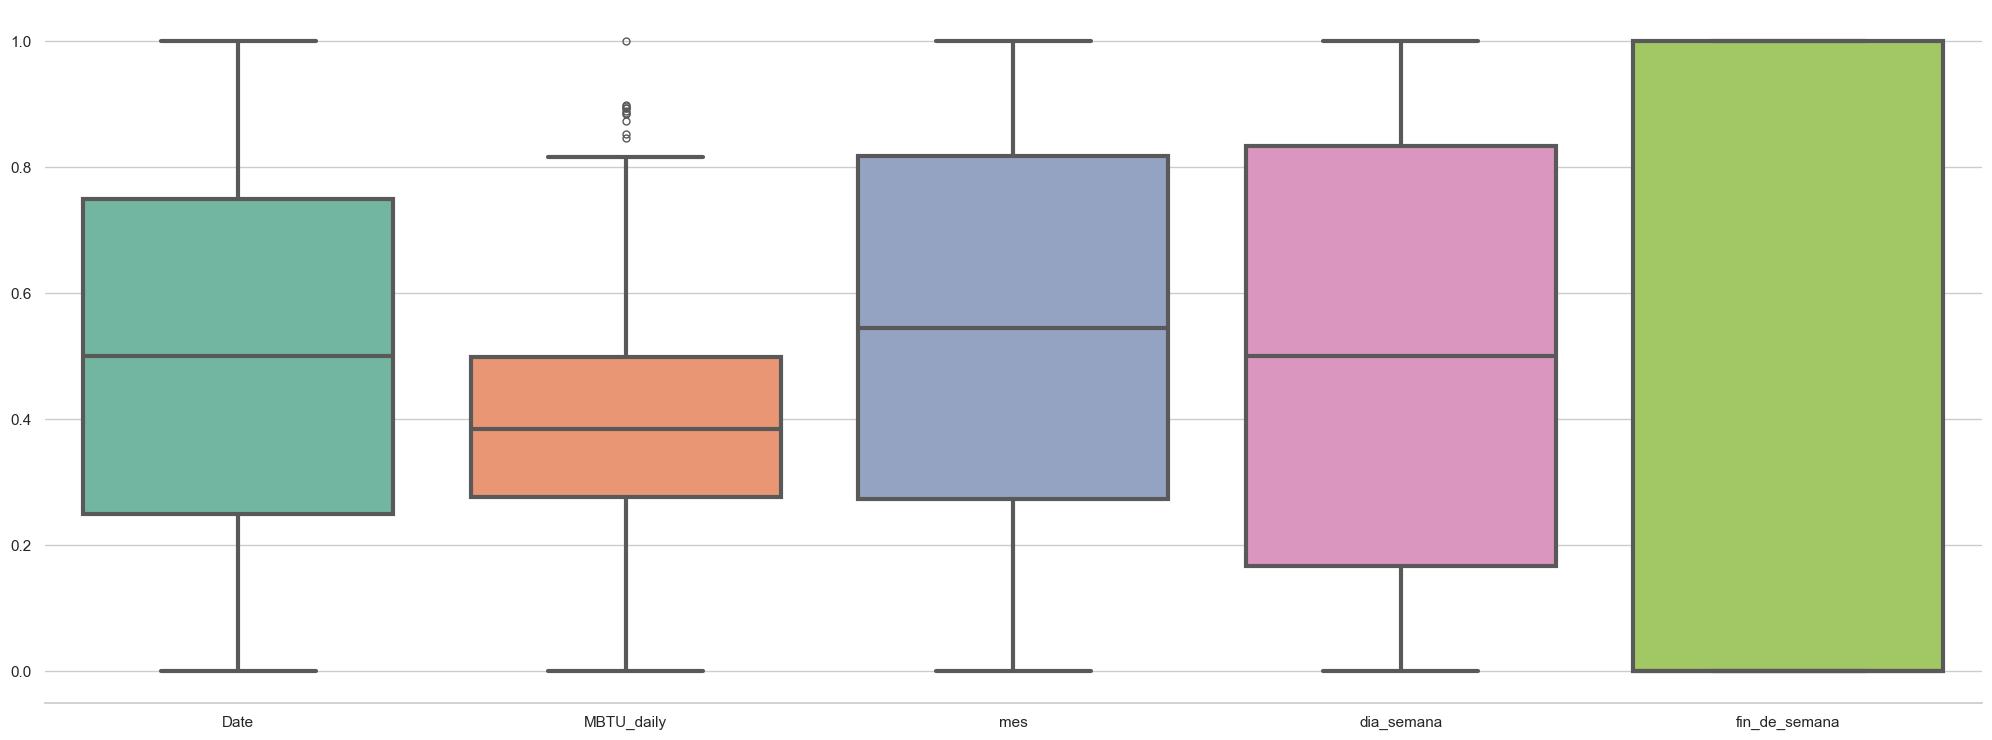

In [14]:
# Revisión de datos atipicos

df_consumo_normalizada = (df_agrupado - df_agrupado.min())/(df_agrupado.max() - df_agrupado.min())

sns.set(rc={'figure.figsize':(25,9)})
sns.set(style="whitegrid")
sns.boxplot(data = df_consumo_normalizada, linewidth = 3,
            palette="Set2", fliersize = 5)
sns.despine(left=True)

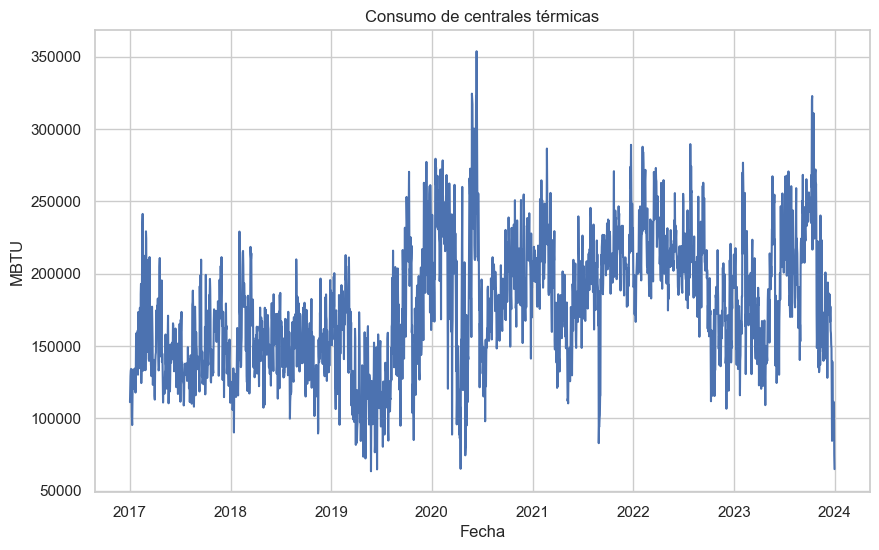

In [15]:
# Grafica exploratoria de datos apartir de una fecha inicio y fin que se encuentren en el rango inicial de descarga.
df_agrupado['Date'] = pd.to_datetime(df_agrupado['Date'])
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_agrupado[(df_agrupado['Date'] >= fecha_inicio) & (df_agrupado['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['MBTU_daily'])
plt.title('Consumo de centrales térmicas')
plt.xlabel('Fecha')
plt.ylabel('MBTU')
plt.grid(True)
plt.show()

#### **Lectura de los datos de aportes hidricos al sistema de generación hidroeléctrico.**

In [16]:
# Lectura de datos crudos de Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo durante el periodo 2017-2023.
# Valores de Caudal en m3/segundo.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)
df_AportesH2O = objetoAPI.request_data("AporCaudal",
                                    "Rio",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_AportesH2O

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


,Id,Name,Value,Date
0,Rio,A. SAN LORENZO,22.080,2023-12-26
1,Rio,ALTOANCHICAYA,76.090,2023-12-26
2,Rio,AMOYA,12.820,2023-12-26
3,Rio,BATA,22.910,2023-12-26
4,Rio,BETANIA CP,158.939,2023-12-26
...,...,...,...,...
895,Rio,PRADO,117.520,2017-01-30
896,Rio,SAN CARLOS,74.133,2017-01-30
897,Rio,SINU URRA,130.620,2017-01-30
898,Rio,SOGAMOSO,178.131,2017-01-30


In [17]:
# Se agrupan los datos por fecha y se suman los valores de MBTU
df_AportesH2O = df_AportesH2O.groupby('Date')['Value'].sum().reset_index()
df_AportesH2O['Date'] = pd.to_datetime(df_AportesH2O['Date'])
df_AportesH2O

,Date,Value
0,2017-01-01,2072.490
1,2017-01-02,1872.113
2,2017-01-03,1531.154
3,2017-01-04,1468.189
4,2017-01-05,1655.904
...,...,...
2544,2023-12-27,2372.738
2545,2023-12-28,2327.821
2546,2023-12-29,2560.345
2547,2023-12-30,2452.609


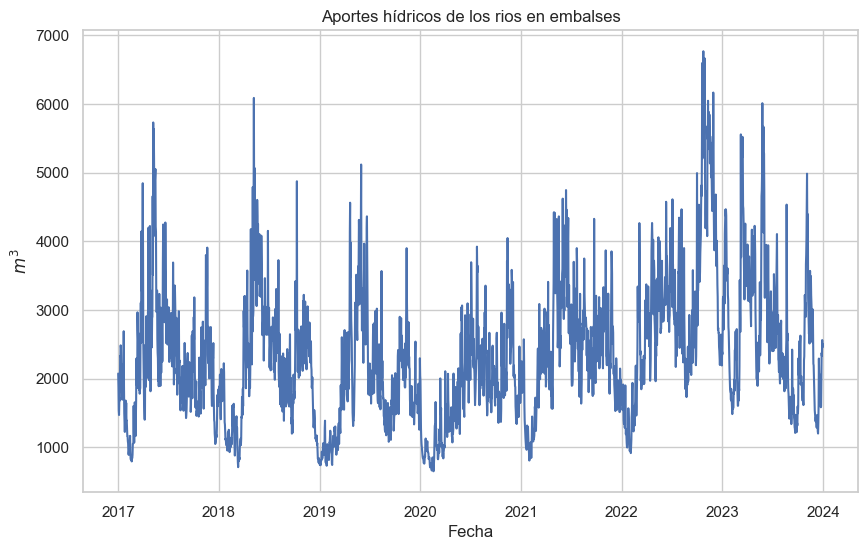

In [18]:
# Filtrado de datos en inicio y fin
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")
df_rango = df_AportesH2O[(df_AportesH2O['Date'] >= fecha_inicio) & (df_AportesH2O['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['Value'])
plt.title('Aportes hídricos de los rios en embalses')
plt.xlabel('Fecha')
plt.ylabel('$m^3$')
plt.grid(True)
plt.show()

In [19]:
df_consumos = df_agrupado.merge(df_AportesH2O[['Date', 'Value']], how='left', on='Date').reset_index(drop=True)

df_consumos

,Date,MBTU_daily,mes,dia_semana,fin_de_semana,Value
0,2017-01-01,111125.1939,1,7,1,2072.490
1,2017-01-02,121709.4724,1,1,0,1872.113
2,2017-01-03,129139.7813,1,2,0,1531.154
3,2017-01-04,132915.7968,1,3,0,1468.189
4,2017-01-05,134121.5011,1,4,0,1655.904
...,...,...,...,...,...,...
2551,2023-12-27,110657.3533,12,3,0,2372.738
2552,2023-12-28,111378.0145,12,4,0,2327.821
2553,2023-12-29,109553.5381,12,5,0,2560.345
2554,2023-12-30,74725.1900,12,6,1,2452.609


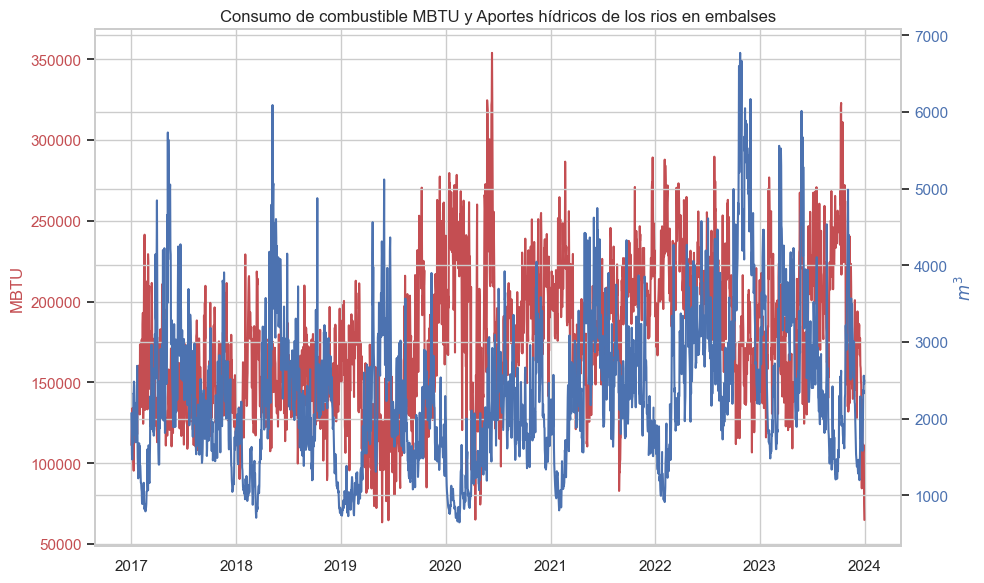

In [20]:
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_consumos[(df_consumos['Date'] >= fecha_inicio) & (df_consumos['Date'] <= fecha_fin)]

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
ax1.plot(df_rango['Date'], df_rango['MBTU_daily'], color='r', label='Consumo de combustible MBTU')
ax1.set_ylabel('MBTU', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje (por ejemplo, 'OtherValue')
ax2.plot(df_rango['Date'], df_rango['Value'], color='b', label='Aportes hídricos')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('$m^3$', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Título de la gráfica
plt.title('Consumo de combustible MBTU y Aportes hídricos de los rios en embalses')

# Mostrar la gráfica
fig.tight_layout()
plt.show()

#### **Correlación entre el comsumo de combustible y los aportes hídricos del sistema**

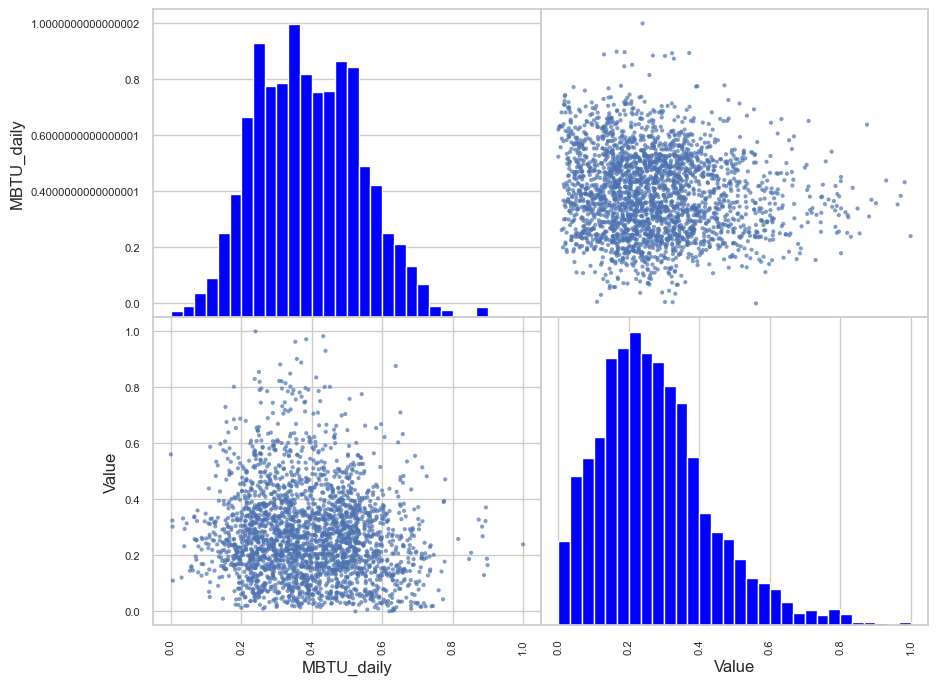

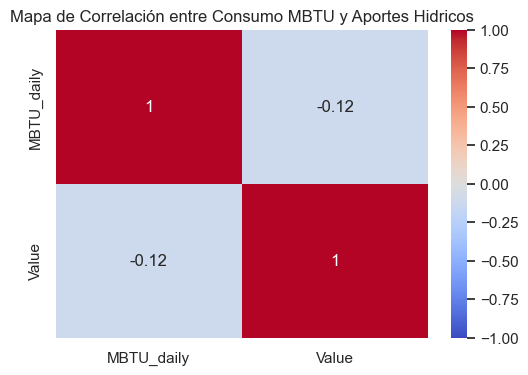

In [21]:
data_consumo_normalizada = df_consumos[['MBTU_daily', 'Value']]
data_consumo_normalizada = (data_consumo_normalizada - data_consumo_normalizada.min())/(data_consumo_normalizada.max() - data_consumo_normalizada.min())

pd.plotting.scatter_matrix(data_consumo_normalizada, alpha=0.7, figsize=(10, 8), range_padding = 0.1, diagonal='hist',
                            hist_kwds = {'bins':30, 'color':'blue'})
plt.show()

# Calcular la matriz de correlación
correlacion = data_consumo_normalizada.corr()

# Crear un mapa de calor para visualizar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación entre Consumo MBTU y Aportes Hidricos')
plt.show()

### **Análisis de correlación con el precio en bolsa Nacional**

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


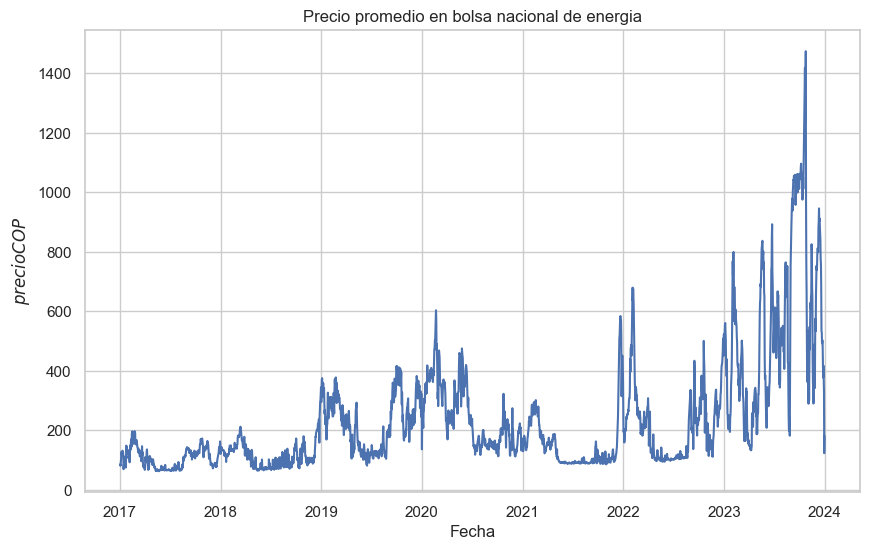

In [22]:
# Lectura de datos crudos de Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo durante el periodo 2017-2023.
# Valores de Caudal en m3/segundo.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)

df_precios = objetoAPI.request_data("PrecBolsNaci",
                                    "Sistema",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_precios

# Los valores nulos se inicializan con cero, esto se realiza, ya que en los datos los momentos en que una central térmica no esta generando energía se muestran como Nan.
df_precios = df_precios.fillna(0)
# Se suman los valores horarios correspondientes a las 24 horas de un día para tener una variable de consumo diario.
df_precios['Precios_diarios'] = df_precios.mean(axis=1, numeric_only=True)

# Se agrupan los datos por fecha y se promedia el valor de precio en bolsa por día
df_precios = df_precios.groupby('Date')['Precios_diarios'].sum().reset_index()
df_precios['Date'] = pd.to_datetime(df_precios['Date'])

# Filtrado de datos en inicio y fin
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")
df_rango = df_precios[(df_precios['Date'] >= fecha_inicio) & (df_precios['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['Precios_diarios'])
plt.title('Precio promedio en bolsa nacional de energia')
plt.xlabel('Fecha')
plt.ylabel('$precio COP$')
plt.grid(True)
plt.show()

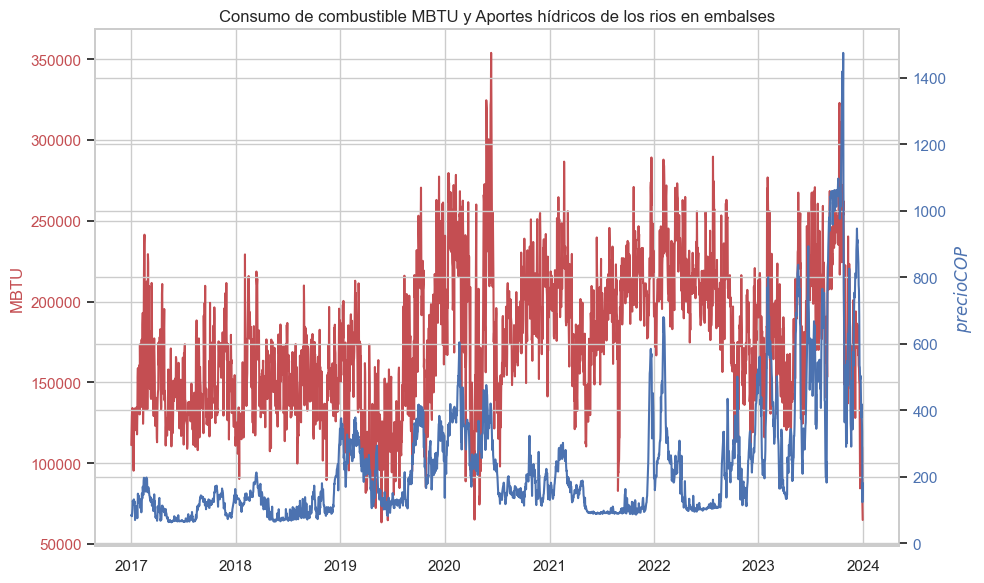

In [23]:
df_consumos_precios = df_agrupado.merge(df_precios[['Date', 'Precios_diarios']], how='left', on='Date').reset_index(drop=True)

fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio) & (df_consumos_precios['Date'] <= fecha_fin)]

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
ax1.plot(df_rango['Date'], df_rango['MBTU_daily'], color='r', label='Consumo de combustible MBTU')
ax1.set_ylabel('MBTU', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje (por ejemplo, 'OtherValue')
ax2.plot(df_rango['Date'], df_rango['Precios_diarios'], color='b', label='Precio en bolsa')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('$precio COP$', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Título de la gráfica
plt.title('Consumo de combustible MBTU y Aportes hídricos de los rios en embalses')

# Mostrar la gráfica
fig.tight_layout()
plt.show()

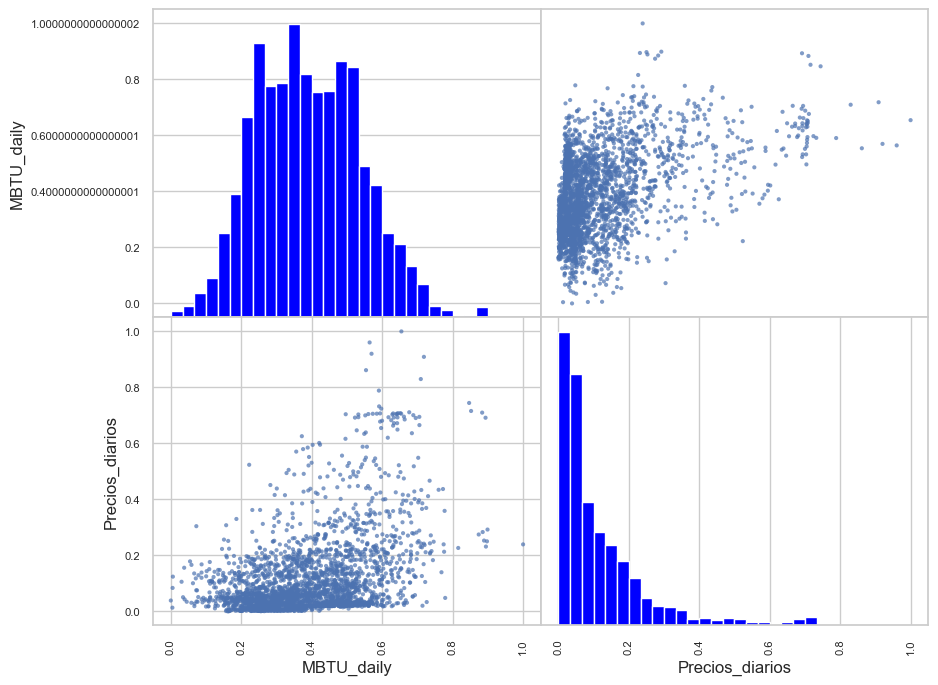

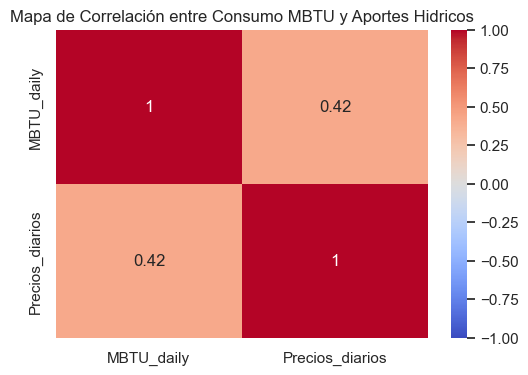

In [24]:
data_consumo_normalizada = df_consumos_precios[['MBTU_daily', 'Precios_diarios']]
data_consumo_normalizada = (data_consumo_normalizada - data_consumo_normalizada.min())/(data_consumo_normalizada.max() - data_consumo_normalizada.min())

pd.plotting.scatter_matrix(data_consumo_normalizada, alpha=0.7, figsize=(10, 8), range_padding = 0.1, diagonal='hist',
                            hist_kwds = {'bins':30, 'color':'blue'})
plt.show()

# Calcular la matriz de correlación
correlacion = data_consumo_normalizada.corr()

# Crear un mapa de calor para visualizar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación entre Consumo MBTU y Aportes Hidricos')
plt.show()

### Parte 3. Creación de datasets para entrenamiento y prueba de los modelos predictivos.
- Se debe considerar si es necesario excluir del estudio una epoca

In [25]:
# Conjunto de datos de entrenamiento y prueba para el modelo Sarimax y otros

# Separar las características (X) y la variable objetivo (y)
X = df_agrupado.drop(columns=['MBTU_daily'])  # Características
y = df_agrupado['MBTU_daily']  # Variable objetivo

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'test_size' especifica la proporción de datos que se utilizarán para el conjunto de prueba (en este caso, 20%)
# 'random_state' asegura que la división sea reproducible

# Ahora tienes tus datos divididos en X_train, X_test (características) y y_train, y_test (variable objetivo)
# Puedes utilizar X_train y y_train para entrenar tu modelo y X_test para evaluar su rendimiento


In [26]:
# Paso 2: Normalización de datos
scaler = MinMaxScaler()
df_agrupado['MBTU_daily'] = scaler.fit_transform(df_agrupado['MBTU_daily'].values.reshape(-1, 1))

# Paso 3: Creación de secuencias
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 2  # Longitud de la secuencia
X = create_sequences(df_agrupado['MBTU_daily'].values, sequence_length)
y = df_agrupado['MBTU_daily'].values[sequence_length:]

# Paso 4: División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# X_train y y_train serán utilizados para entrenar el modelo de RNN
# X_test y y_test serán utilizados para evaluar el rendimiento del modelo
X_train

array([[0.16449366, 0.20092571],
       [0.20092571, 0.22650151],
       [0.22650151, 0.23949889],
       ...,
       [0.49681368, 0.53595452],
       [0.53595452, 0.4682145 ],
       [0.4682145 , 0.46303876]])

**Parte 4.** Análisis exploratorio de verificaciones en serie de tiempo.

- Se realiza análisis de estacionalidad, tendencia y error de los datos.
- Se reliza test de dicked fuller.
- El análisis y pruebas se realizan en base al dataframe "df_rango" en un rango particular de datos.

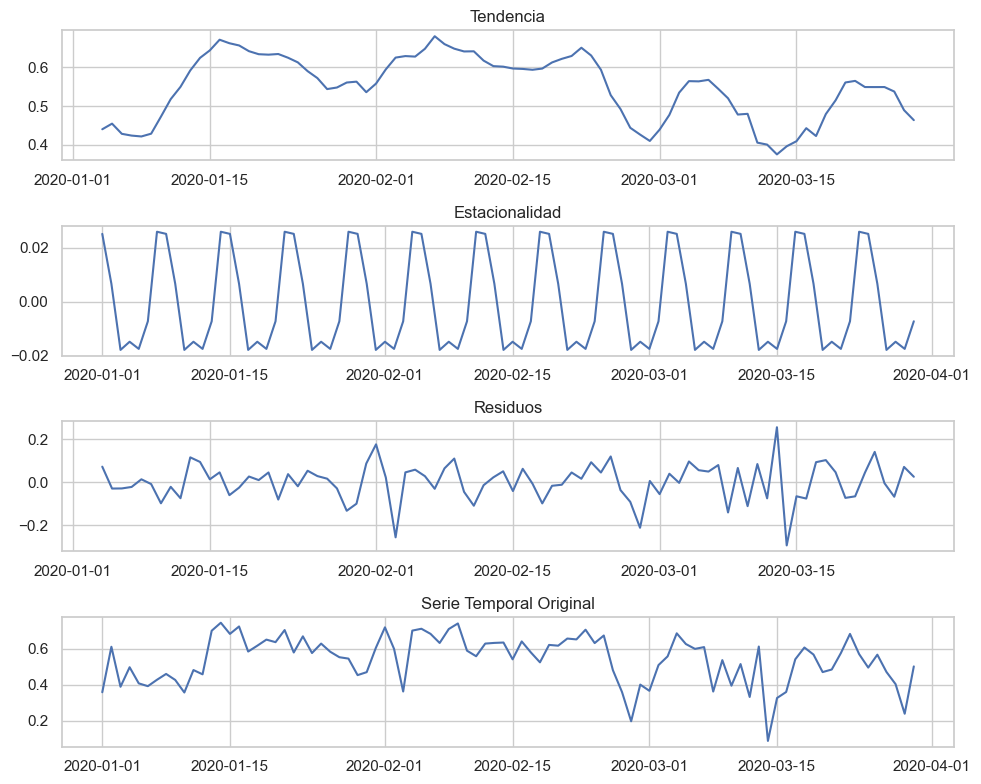

In [113]:
fecha_inicio_descom = dt.datetime.strptime("2020-1-1", "%Y-%m-%d")
fecha_fin_descom = dt.datetime.strptime("2020-3-30", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango_descom = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio_descom) & (df_consumos_precios['Date'] <= fecha_fin_descom)]

# Descomposición de series temporales
df_rango_descom.set_index('Date', inplace=True)
decomposition = seasonal_decompose(df_rango_descom['MBTU_daily'], model='additive')
# Visualización de la descomposición
plt.figure(figsize=(10, 8))

# Tendencia
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendencia')

# Estacionalidad
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')

# Residuos
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuos')

# Serie Temporal Original
plt.subplot(414)
plt.plot(df_rango_descom['MBTU_daily'])
plt.title('Serie Temporal Original')

plt.tight_layout()
plt.show()

**Análisis resultados**
Se puede notar en la descomposición de la serie temporal se tiene una tendencia variante en el tiempo sin un patro muy claro. Una parte estacional que tiene concordancia con los datos pero de la mano con residuos de esta descomposición que tienen un comportamiento variable en los diferentes años.

In [28]:
# Test de Dicked Fuller
# Aplicar el test de Dickey-Fuller
result = sm.tsa.adfuller(df_rango['MBTU_daily'])

# Mostrar los resultados del test
print('Estadística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])

# Interpretación de los resultados
if result[1] <= 0.05:
    print("La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).")
else:
    print("La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula de la presencia de una raíz unitaria).")

Estadística ADF: -4.210002537144271
Valor p: 0.000633677379122661
Valores críticos: {'1%': -3.432939379929173, '5%': -2.862683979868293, '10%': -2.5673789838429837}
La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).


## **Parte 4.** Modelación con SARIMAX

ADF Statistic: -4.210002537144309
p-value: 0.0006336773791225694
La serie es estacionaria


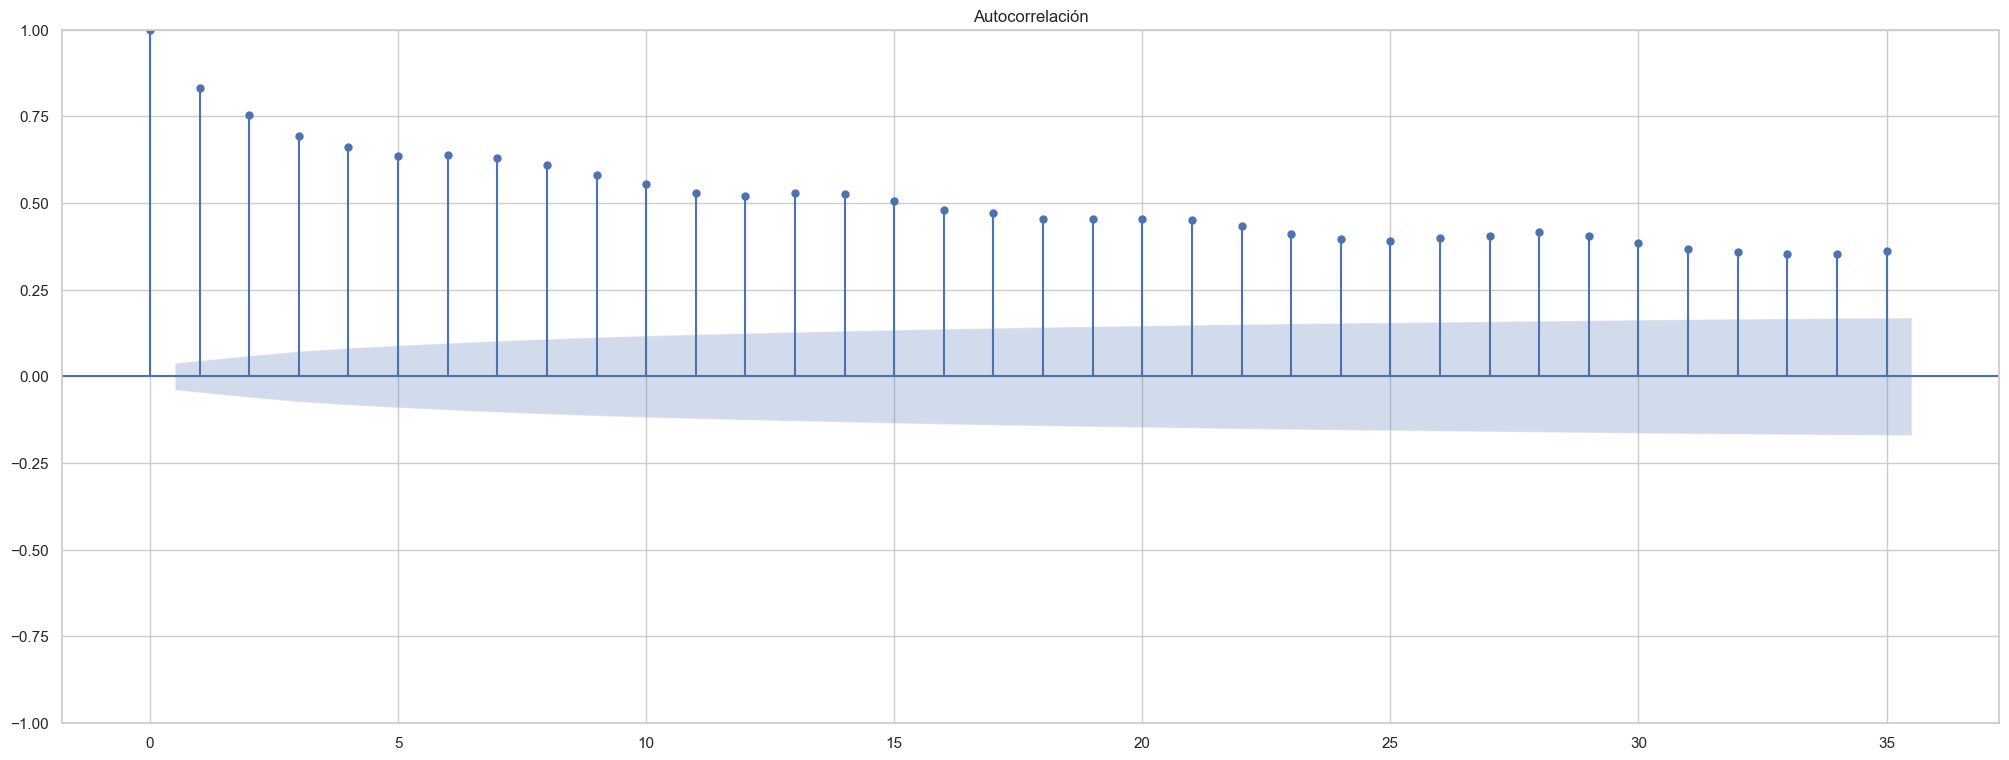

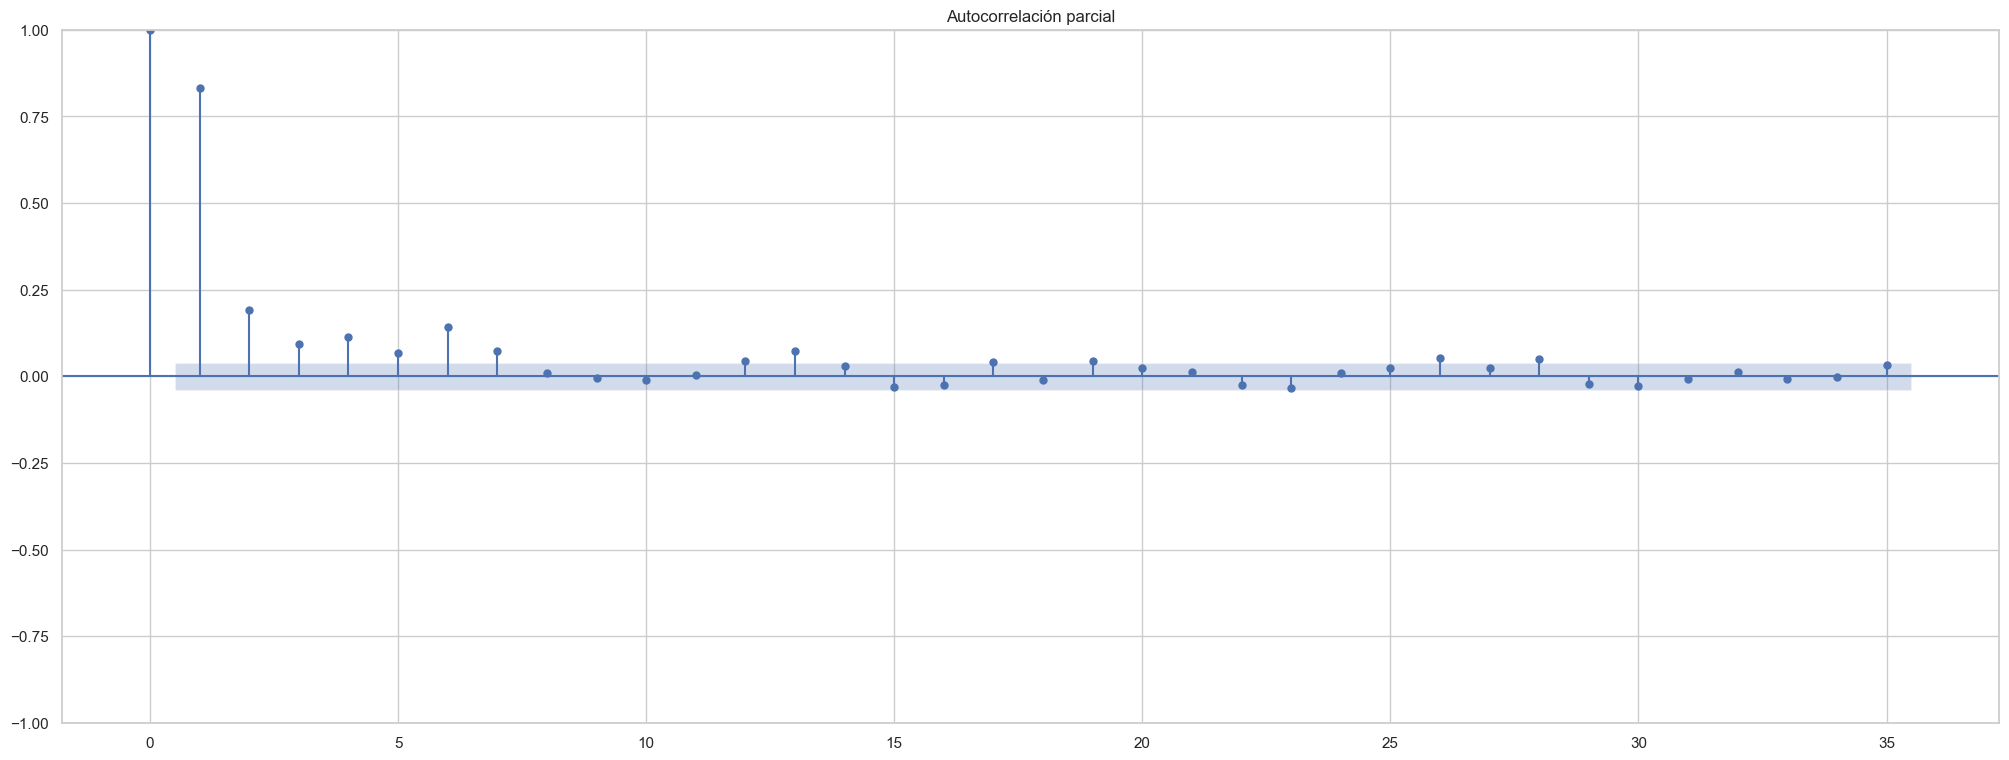

In [114]:
# Test de estacionalidad
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print('La serie es estacionaria')
    else:
        print('La serie no es estacionaria')

test_stationarity(df_consumos_precios['MBTU_daily'])


plot_acf(df_consumos_precios['MBTU_daily'].dropna())
plt.title('Autocorrelación')
plt.show()

plot_pacf(df_consumos_precios['MBTU_daily'].dropna())
plt.title('Autocorrelación parcial')
plt.show()

In [ ]:
# Diferenciación para hacer la serie estacionaria (en caso de ser necesario)
df_consumos_precios['diferencia'] = df_consumos_precios['MBTU_daily'].diff()
test_stationarity(df_consumos_precios['diferencia'].dropna())

plot_acf(df_consumos_precios['diferencia'].dropna())
plt.title('Autocorrelación')
plt.show()

plot_pacf(df_consumos_precios['diferencia'].dropna())
plt.title('Autocorrelación parcial')
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                          MBTU_daily   No. Observations:                 2300
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 7)   Log Likelihood                2677.410
Date:                           mié., 09 oct. 2024   AIC                          -5338.821
Time:                                     20:48:38   BIC                          -5292.920
Sample:                                          0   HQIC                         -5322.083
                                            - 2300                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Precios_diarios     0.7378      0.060     12.356      0.000       0.621       0.855
ar.L1       

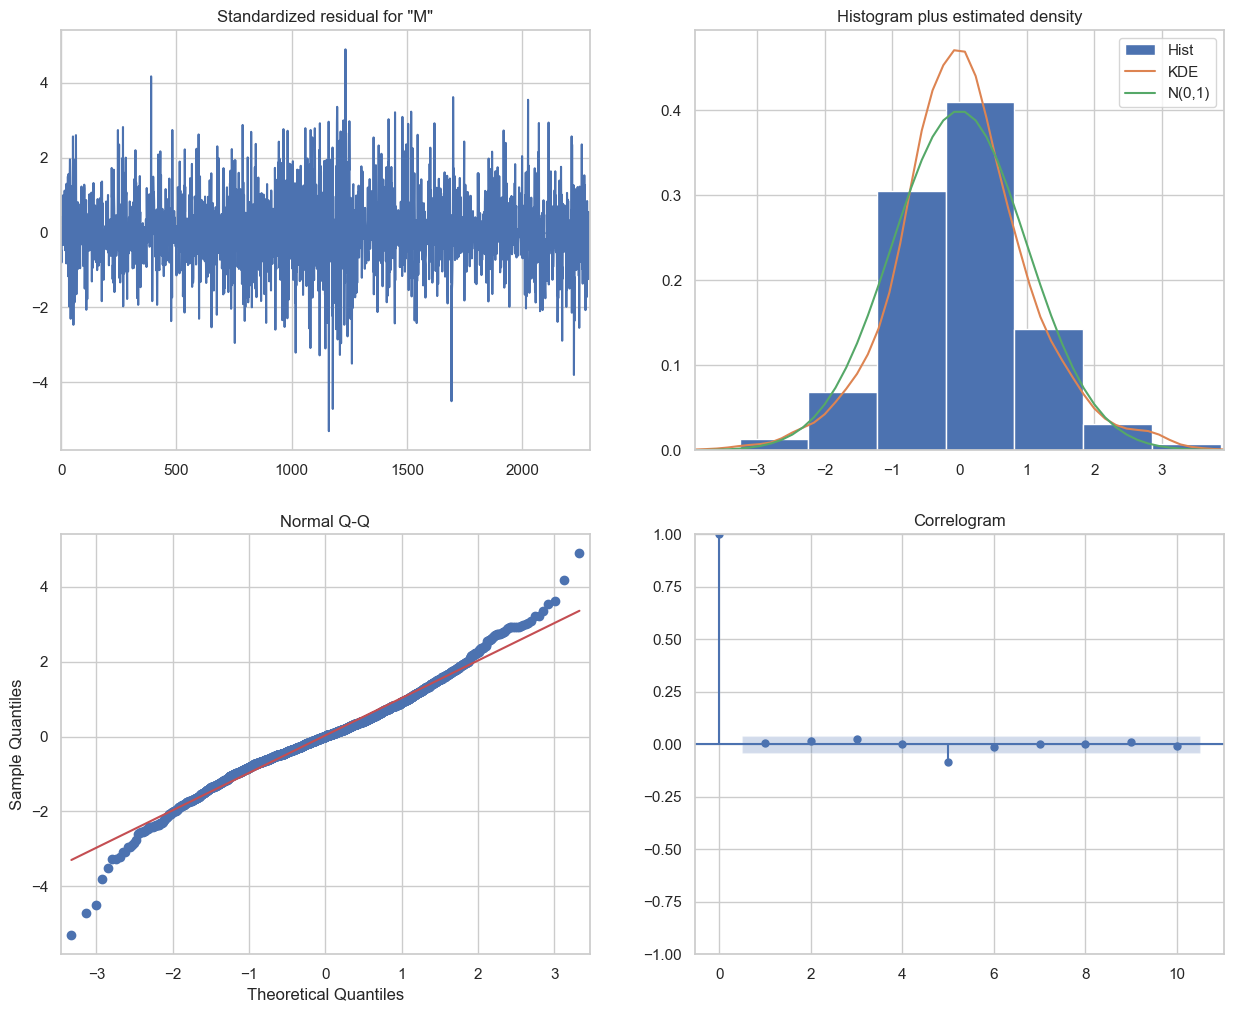

In [115]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Dividir los datos en conjunto de entrenamiento y prueba
train_size = int(len(df_consumos_precios) * 0.9)
train, test = df_consumos_precios[:train_size], df_consumos_precios[train_size:]

# Inclusión de variable exogena
# Asegúrate de que la variable exógena esté en ambos conjuntos
X_train = train[['Precios_diarios']]  # Ajusta según el nombre de tu variable
X_test = test[['Precios_diarios']]

# Definir parámetros (p, d, q) y (P, D, Q, s)
p, d, q = 1, 0, 3  # Estos valores se ajustan según los resultados de ACF/PACF
P, D, Q, s = 1, 1, 1, 7  # Frecuencia s = 7 para periodos semanales.

# Ajustar el modelo con la variable exógena
model_simple = SARIMAX(train['MBTU_daily'], 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s))

# Ajustar el modelo con la variable exógena
model_exog = SARIMAX(train['MBTU_daily'], 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s), 
                exog=X_train)

results_simple = model_simple.fit()
results = model_exog.fit()

# Resumen del modelo
print(results.summary())

# Gráficos de diagnóstico
results.plot_diagnostics(figsize=(15, 12))
plt.show()

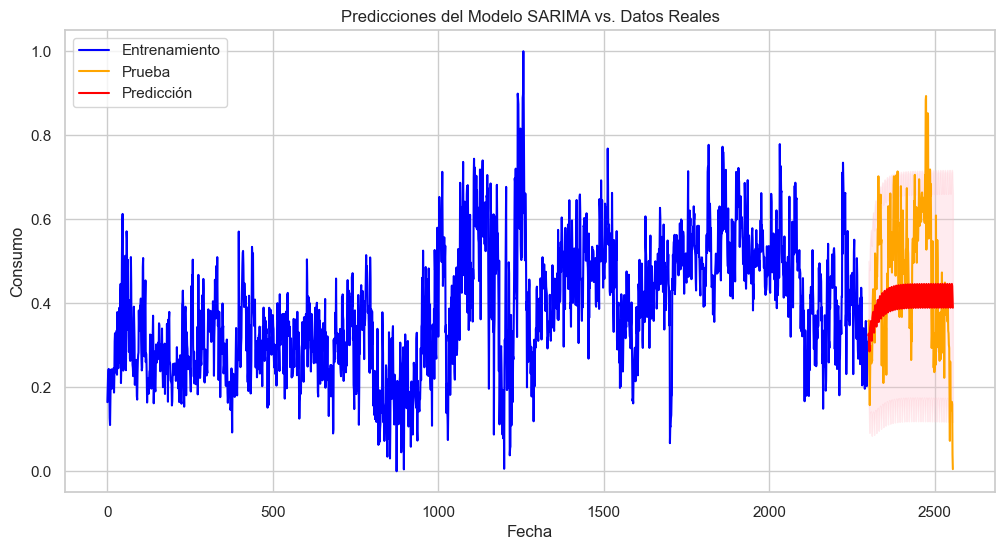

In [116]:
# Predicción futura
# Hacer predicciones sobre el conjunto de prueba
pred_simple = results_simple.get_forecast(steps=len(test))
pred_conf_simple = pred_simple.conf_int()

# Visualizar predicciones
plt.figure(figsize=(12, 6))
# Graficar datos de entrenamiento
plt.plot(train['MBTU_daily'], label='Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(test['MBTU_daily'], label='Prueba', color='orange')

# Graficar predicciones
plt.plot(pred_simple.predicted_mean.index, pred_simple.predicted_mean, label='Predicción', color='red')

# Graficar intervalos de confianza
plt.fill_between(pred_conf_simple.index, pred_conf_simple.iloc[:, 0], pred_conf_simple.iloc[:, 1], color='pink', alpha=0.3)

# Configuración del gráfico
plt.title('Predicciones del Modelo SARIMA vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

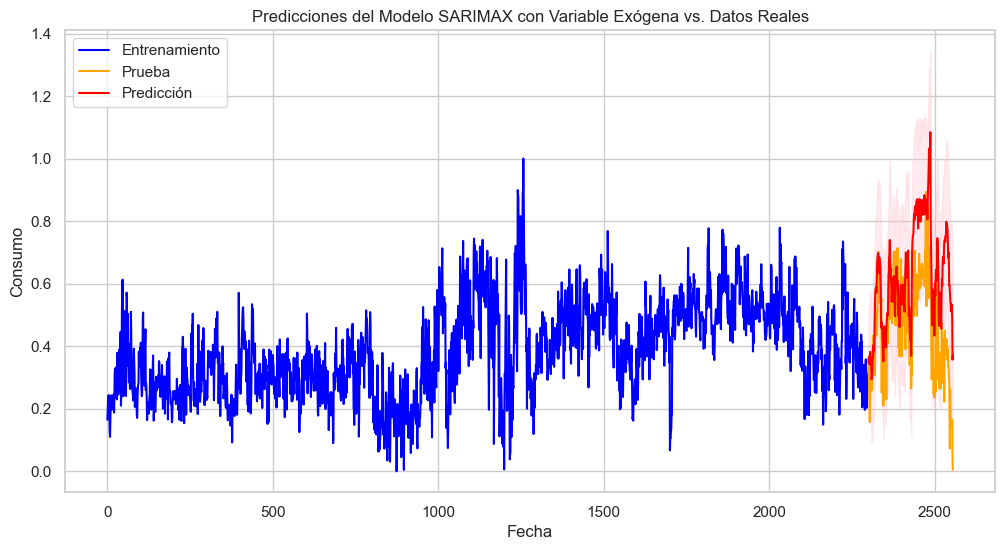

In [118]:
# Predicción futura
# Hacer predicciones sobre el conjunto de prueba
pred = results.get_forecast(steps=len(test), exog=X_test)
pred_conf = pred.conf_int()

# Visualizar predicciones
plt.figure(figsize=(12, 6))
# Graficar datos de entrenamiento
plt.plot(train['MBTU_daily'], label='Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(test['MBTU_daily'], label='Prueba', color='orange')

# Graficar predicciones
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Predicción', color='red')

# Graficar intervalos de confianza
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

# Configuración del gráfico
plt.title('Predicciones del Modelo SARIMAX con Variable Exógena vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [119]:
# Evaluación del modelo.

# Predicciones y valores reales
predicciones = pred.predicted_mean
valores_reales = test['MBTU_daily']

# Calcular las métricas
mse = np.mean((predicciones - valores_reales) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predicciones - valores_reales))
mape = np.mean(np.abs((predicciones - valores_reales) / valores_reales)) * 100

# Mostrar las métricas
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

Error Cuadrático Medio (MSE): 0.04
Raíz del Error Cuadrático Medio (RMSE): 0.21
Error Absoluto Medio (MAE): 0.17
Error Porcentual Absoluto Medio (MAPE): 78.44%


## **Parte 5.** Modelación con Red Neural LSTM

In [63]:
scaler_Gas = MinMaxScaler()
scaler_Precios = MinMaxScaler()

df_consumos_scaler = scaler_Gas.fit_transform(df_consumos_precios[['MBTU_daily']])
df_consumos_scaler_precios = scaler_Precios.fit_transform(df_consumos_precios[['Precios_diarios']])

df_consumos_scaler = pd.DataFrame(df_consumos_scaler, columns = ['MBTU_daily'])
df_consumos_scaler_precios = pd.DataFrame(df_consumos_scaler_precios, columns = ['Precios_diarios'])
print(df_consumos_scaler.head(8))

# Dividir los datos en entrenamiento y prueba
train_size = int(len(df_consumos_precios['MBTU_daily']) * 0.9)
test_size = int(len(df_consumos_precios['MBTU_daily']) * 0.1)

train, test = df_consumos_scaler['MBTU_daily'][:train_size], df_consumos_scaler['MBTU_daily'][train_size:]

   MBTU_daily
0    0.164494
1    0.200926
2    0.226502
3    0.239499
4    0.243649
5    0.225055
6    0.190477
7    0.126809


In [107]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        # Access data using iloc for integer-location based indexing
        a = data.iloc[i : (i + time_step), 0].values
        X.append(a)
        y.append(data.iloc[i + time_step, 0]) # Access data using iloc
    return np.array(X), np.array(y)

# Parámetros
time_step = 7  # Uso 7 días para predecir el siguiente

X, y = create_dataset(df_consumos_scaler, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape para LSTM


# División de los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [70]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1)) # predicción de un valor

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir la normalización
train_predict = scaler_Gas.inverse_transform(train_predict)
test_predict = scaler_Gas.inverse_transform(test_predict)

# Obtener los valores reales
y_train_inv = scaler_Gas.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_Gas.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0503
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 16/50
72/72 ━

Error Cuadrático Medio (MSE): 592030758.99
Raíz del Error Cuadrático Medio (RMSE): 24331.68
Error Absoluto Medio (MAE): 18820.98
Error Porcentual Absoluto Medio (MAPE): 10.22%


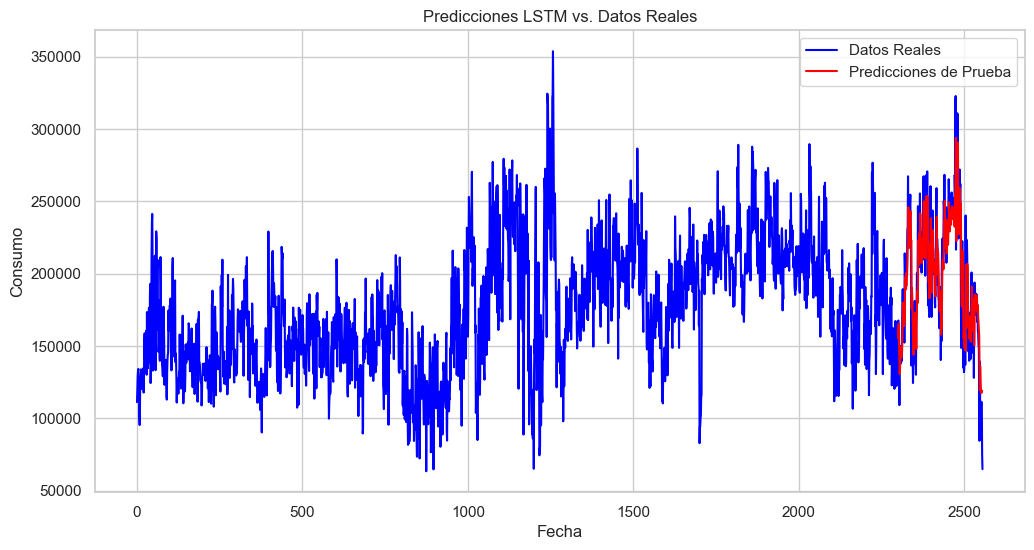

In [84]:
mse = np.mean((test_predict - y_test_inv) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_predict - y_test_inv))
mape = np.mean(np.abs((test_predict - y_test_inv) / y_test_inv)) * 100

print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(scaler_Gas.inverse_transform(df_consumos_scaler.values.reshape(-1, 1)), label='Datos Reales', color='blue')
#plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Predicciones de Entrenamiento', color='green')
plt.plot(np.arange(time_step + len(train_predict), len(df_consumos_precios) - 1), test_predict, label='Predicciones de Prueba', color='red')
plt.title('Predicciones LSTM vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [91]:
def create_dataset(data, exog, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        # Extraer el consumo y la variable exógena
        X.append(np.concatenate((data[i:(i + time_step)], exog[i:(i + time_step)]), axis=1))
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [92]:


# Normalizar'MBTU_daily'y variable exógena
scaler_consumo = MinMaxScaler(feature_range=(0, 1))
df_consumos_precios['MBTU_daily'] = scaler_consumo.fit_transform(df_consumos_precios[['MBTU_daily']])

scaler_exog = MinMaxScaler(feature_range=(0, 1))
df_consumos_precios['Precios_diarios'] = scaler_exog.fit_transform(df_consumos_precios[['Precios_diarios']])

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(df_consumos_precios) * 0.9)
train, test = df_consumos_precios[:train_size], df_consumos_precios[train_size:]

# Crear datasets
X_train, y_train = create_dataset(train[['MBTU_daily']].values, train[['Precios_diarios']].values, time_step)
X_test, y_test = create_dataset(test[['MBTU_daily']].values, test[['Precios_diarios']].values, time_step)

# Reshape para LSTM [muestras, pasos de tiempo, características]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)  # Cambiar a 2 para incluir la exógena
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 2)

In [94]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 2)))  # Cambiar a 2 para incluir la exógena
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicción de un valor

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir la normalización
train_predict = scaler_consumo.inverse_transform(train_predict)
test_predict = scaler_consumo.inverse_transform(test_predict)

# Obtener los valores reales
y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0448
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075
Epoch 16/50
72/72 ━

Error Cuadrático Medio (MSE): 0.01
Raíz del Error Cuadrático Medio (RMSE): 0.08
Error Absoluto Medio (MAE): 0.06
Error Porcentual Absoluto Medio (MAPE): 22.58%


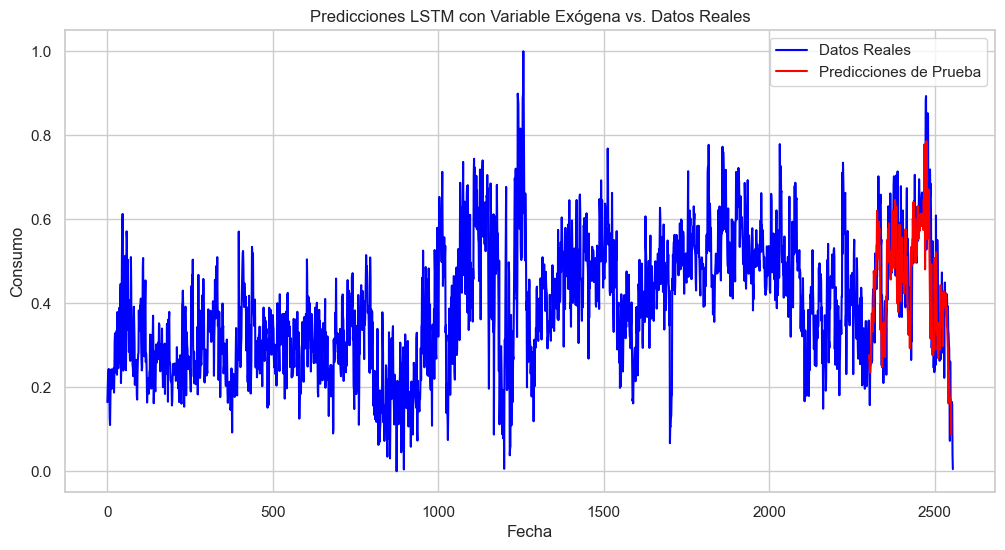

In [103]:
mse = np.mean((test_predict - y_test_inv) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_predict - y_test_inv))
mape = np.mean(np.abs((test_predict - y_test_inv) / y_test_inv)) * 100

print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(scaler_consumo.inverse_transform(df_consumos_precios['MBTU_daily'].values.reshape(-1, 1)), label='Datos Reales', color='blue')
#plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Predicciones de Entrenamiento', color='green')
plt.plot(np.arange(time_step + len(train_predict) + 2, len(df_consumos_precios) - time_step+2), test_predict, label='Predicciones de Prueba', color='red')
plt.title('Predicciones LSTM con Variable Exógena vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()


In [109]:
# Construir el modelo GRU
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # 1 característica
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicción de un valor

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir la normalización
train_predict = scaler_consumo.inverse_transform(train_predict)
test_predict = scaler_consumo.inverse_transform(test_predict)

# Obtener los valores reales
y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0409
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069
Epoch 16/50
72/72 ━

Error Cuadrático Medio (MSE): 0.01
Raíz del Error Cuadrático Medio (RMSE): 0.08
Error Absoluto Medio (MAE): 0.07
Error Porcentual Absoluto Medio (MAPE): 18.68%


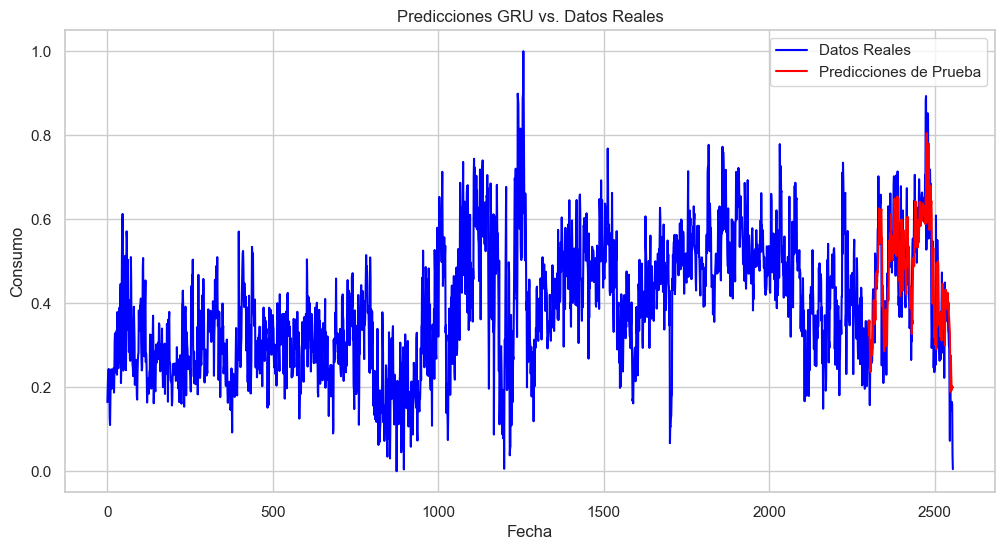

In [111]:
# Calcular métricas de evaluación
mse = np.mean((test_predict.flatten() - y_test_inv.flatten()) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_predict.flatten() - y_test_inv.flatten()))
mape = np.mean(np.abs((test_predict.flatten() - y_test_inv.flatten()) / y_test_inv.flatten())) * 100

# Mostrar las métricas
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(scaler_consumo.inverse_transform(df_consumos_precios['MBTU_daily'].values.reshape(-1, 1)), label='Datos Reales', color='blue')
#plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Predicciones de Entrenamiento', color='green')
plt.plot(np.arange(time_step + len(train_predict) + 1, len(df_consumos_precios)), test_predict, label='Predicciones de Prueba', color='red')
plt.title('Predicciones GRU vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()